In [1]:
import numpy as np
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold, ParameterGrid

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of compounds", df.shape[0])
    return df

In [3]:
def drop_low_frequency_elements(df, limit):
    elem_counts = pd.Series(np.hstack(np.array(df.species))).value_counts()
    low_freq = elem_counts[elem_counts < limit].index.values
    low_freq_mask = df.species.apply(lambda s: len(np.setdiff1d(s, low_freq)) < len(s))
    df = df[~low_freq_mask]
    print("Number of compounds", df.shape[0])
    return df

In [4]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [5]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            nn.SELU(0.3),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU())
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.SELU(),
                                        nn.Linear(32, 8),
                                        nn.SELU(),
                                        nn.Linear(8, 1))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.regressor(x)
        return x

In [6]:
data_name = "all_221_cp5_3_species_oxides"
fig_folder = "plots/"

In [7]:
df = pd.read_pickle(f"data/{data_name}.pkl")
df = drop_duplicates(df)
df = drop_low_frequency_elements(df, 50)
df

Number of compounds 1983
Number of compounds 1904


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:b778fabdb1b01db1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAlO/T00...,Ag1Al1O3,"[1, 1, 3]","[Ag, Al, O]",5,221,cP5,"[3.7688035, 3.7688035, 3.7688035, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.8844, 1.8844, 1.8844], [0...",-5.04863,-0.775736
2,aflow:272cd0e74db84a51,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAsO/T00...,Ag1As1O3,"[1, 1, 3]","[Ag, As, O]",5,221,cP5,"[3.7951634, 3.7951634, 3.7951634, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.89758, 1.89758, 1.89758],...",-4.55519,-0.100528
4,aflow:7e6bdbc495310b44,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAuO/T00...,Ag1Au1O3,"[1, 1, 3]","[Ag, Au, O]",5,221,cP5,"[4.1003175, 4.1003175, 4.1003175, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [2.05016, 2.05016, 2.05016],...",-2.80408,1.37453
6,aflow:c0e1c25976bb4c75,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgB_hO/T0...,Ag1B1O3,"[1, 1, 3]","[Ag, B, O]",5,221,cP5,"[3.484261, 3.484261, 3.484261, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.74213, 1.74213, 1.74213],...",-4.55549,0.30734
8,aflow:3b79b8b28a5d5cc1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgBa_svO/...,Ag1Ba1O3,"[1, 1, 3]","[Ag, Ba, O]",5,221,cP5,"[4.7271734, 4.7271734, 4.7271734, 90.0, 90.0, ...","[[-0.0, 0.0, -0.0], [0.5, 0.5, 0.5], [-0.0, 0....","[[-0.0, 0.0, -0.0], [2.36359, 2.36359, 2.36359...",-3.52096,0.388015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,aflow:e243d024b0749ac0,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZn/T00...,O3Xe1Zn1,"[3, 1, 1]","[O, Xe, Zn]",5,221,cP5,"[4.370543, 4.370543, 4.370543, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.18527, 2.18527], [2.18527, 0.0, 2.185...",-1.89960,None
3949,aflow:ae4a07b2d68c2933,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZr_sv/...,O3Xe1Zr1,"[3, 1, 1]","[O, Xe, Zr]",5,221,cP5,"[4.322477, 4.322477, 4.322477, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[-0.0, 2.16124, 2.16124], [2.16124, -0.0, 2.1...",-5.89112,-1.222
3951,aflow:0d9d3ce033a32aae,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZn/T...,O3Y1Zn1,"[3, 1, 1]","[O, Y, Zn]",5,221,cP5,"[4.3517566, 4.3517566, 4.3517566, 90.0, 90.0, ...","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.17588, 2.17588], [2.17588, 0.0, 2.175...",-5.57716,-1.07268
3953,aflow:627232532ed2fb40,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZr_s...,O3Y1Zr1,"[3, 1, 1]","[O, Y, Zr]",5,221,cP5,"[4.155165, 4.155165, 4.155165, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.07758, 2.07758], [2.07758, 0.0, 2.077...",-8.70129,-2.74124


In [8]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(62,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'Hf', 'Hg',
        'I', 'In', 'Ir', 'K', 'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb',
        'Ni', 'O', 'Os', 'P', 'Pb', 'Pd', 'Pt', 'Rb', 'Re', 'Rh', 'Ru',
        'S', 'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Tc', 'Te', 'Ti',
        'Tl', 'V', 'W', 'Xe', 'Y', 'Zn', 'Zr'], dtype='<U2'))

In [9]:
net = VoxelNet(nchannel)
count_parameters(net)

73729

## Parameters

In [10]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
weight_decay = 0.01

device = get_default_device()

##  Cartesian

(1523, 13) (190, 13) (191, 13)
Initialised MolLoader with 1523 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 190 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 191 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Epoch 0: train loss 9.1958 val loss 2.4910 test loss 2.7063 -> best val loss!
Epoch 1: train loss 2.3444 val loss 1.9806 test loss 2.3414 -> best val loss!
Epoch 2: train loss 2.0541 val loss 1.7778 test loss 2.1043 -> best val loss!
Epoch 3: train loss 1.9620 val loss 1.6968 te

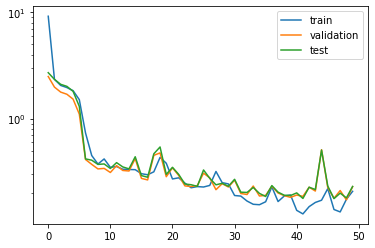

In [11]:
seed_everything()
train_df, holdout_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(holdout_df, test_size=0.5)
print(train_df.shape, val_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     device=device, mode='cartesian')

ml_val = MolLoader(val_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='cartesian')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='cartesian')

best_net = fit(epochs, net, ml_train, ml_val, ml_test, torch.optim.Adam, lr=0.001, weight_decay=weight_decay, val_epochs=5)

### Train Plots

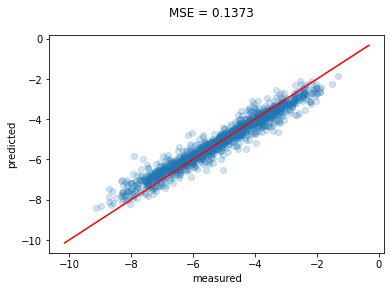

In [12]:
# 0.0681 50 epoch wd=0, L=12.8
# 0.1612 50 epoch wd=0.01, L=10 drop_low_freq
# 0.1485 50 epoch wd=0.01, L=10
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(best_net, ml_pred)
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.show()

Mean Variance:  0.0046418305


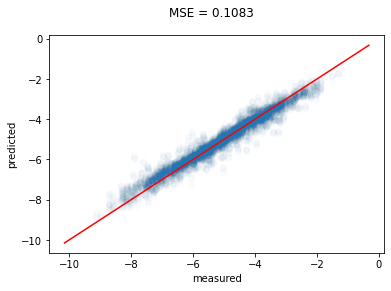

In [13]:
# 0.0431 50 epoch wd=0, L=12.8
# 0.0893 50 epoch wd=0.01, L=10 drop_low_freq
# 0.0850 50 epoch wd=0.01, L=10
# transformations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(best_net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats, alpha=0.01)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_cartesian_train.pdf")

### Test Plots

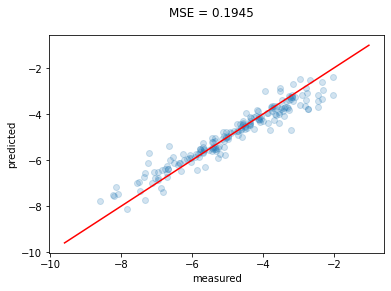

In [14]:
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(best_net, ml_pred)
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.show()

Mean Variance:  0.0045150137


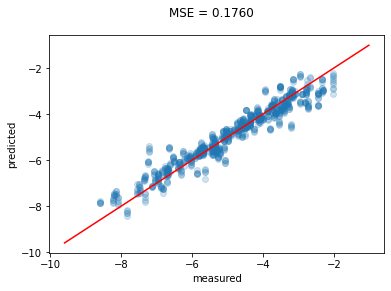

In [15]:
# transformations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(best_net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_cartesian_test.pdf")

## Spherical

(1523, 13) (190, 13) (191, 13)
Initialised MolLoader with 1523 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=spherical, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=spherical
Initialised MolLoader with 190 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=spherical, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=spherical
Initialised MolLoader with 191 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=spherical, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=spherical
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Epoch 0: train loss 9.1936 val loss 2.4647 test loss 2.6787 -> best val loss!
Epoch 1: train loss 2.2964 val loss 1.9240 test loss 2.2718 -> best val loss!
Epoch 2: train loss 1.9211 val loss 1.5994 test loss 1.8930 -> best val loss!
Epoch 3: train loss 1.6141 val loss 1.1865 te

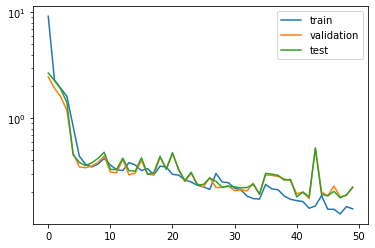

In [16]:
seed_everything()
train_df, holdout_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(holdout_df, test_size=0.5)
print(train_df.shape, val_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     device=device, mode='spherical')

ml_val = MolLoader(val_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='spherical')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='spherical')

best_net = fit(epochs, net, ml_train, ml_val, ml_test, torch.optim.Adam, lr=0.001, weight_decay=weight_decay, val_epochs=5)

### Train Plots

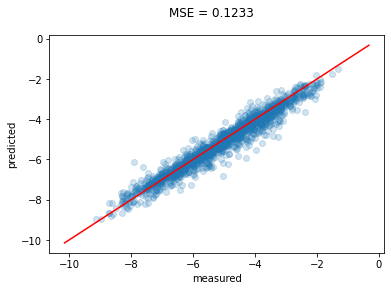

In [17]:
# 0.0596 50 epoch wd=0, L=12.8
# 0.0706 50 epoch wd=0.01, L=10 drop_low_freq
# 0.1183 50 epoch wd=0.01, L=10
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(best_net, ml_pred)
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.show()

Mean Variance:  0.00086986524


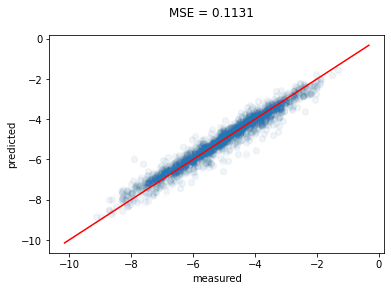

In [18]:
# 0.0932 50 epoch wd=0, L=12.8
# 0.1074 50 epoch wd=0.01, L=10
# transformations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(best_net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats, alpha=0.01)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_spherical_train.pdf")

### Test Plots

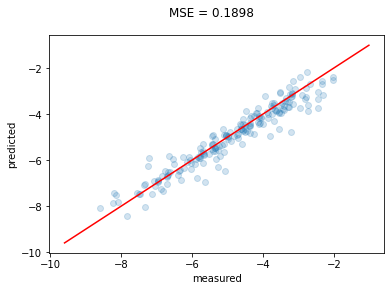

In [19]:
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(best_net, ml_pred)
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.show()

Mean Variance:  0.00083990616


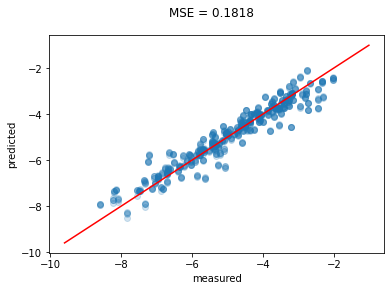

In [20]:
# transformations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(best_net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_spherical_test.pdf")

## Parameter Grid Search

In [10]:
seed_everything()
train_df, holdout_df = train_test_split(df, test_size=0.1)
val_df, test_df = train_test_split(holdout_df, test_size=0.5)
print(train_df.shape, val_df.shape, test_df.shape)

(1713, 13) (95, 13) (96, 13)


In [11]:
param_grid = ParameterGrid({
    "sigma": [0.01, 0.1, 1.],
    "L": [10, 12.8, 15],
    "weight_decay": [0., 0.001, 0.01]
})
N = 32
epochs = 50

In [12]:
len(list(param_grid))

27

0. L = 10, sigma = 0.01, weight_decay = 0.0
Initialised MolLoader with 1713 compounds.
    sigma=0.01, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.01, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.01, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
), number of epochs: 50, validation epochs: 5
Finished in 1872.1172s.                                


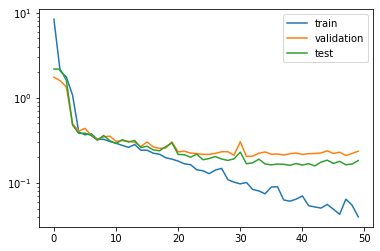

1. L = 10, sigma = 0.01, weight_decay = 0.001
Initialised MolLoader with 1713 compounds.
    sigma=0.01, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.01, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.01, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
), number of epochs: 50, validation epochs: 5
Finished in 1902.6669s.                                


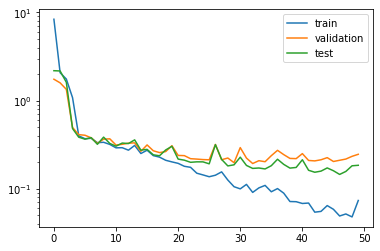

2. L = 10, sigma = 0.01, weight_decay = 0.01
Initialised MolLoader with 1713 compounds.
    sigma=0.01, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.01, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.01, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Finished in 1934.3159s.                                


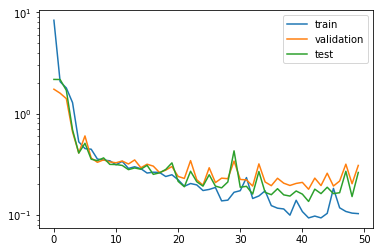

3. L = 10, sigma = 0.1, weight_decay = 0.0
Initialised MolLoader with 1713 compounds.
    sigma=0.1, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.1, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.1, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
), number of epochs: 50, validation epochs: 5
Finished in 1983.0299s.                                


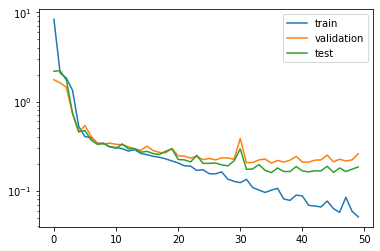

4. L = 10, sigma = 0.1, weight_decay = 0.001
Initialised MolLoader with 1713 compounds.
    sigma=0.1, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.1, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.1, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
), number of epochs: 50, validation epochs: 5
Finished in 1949.4219s.                                


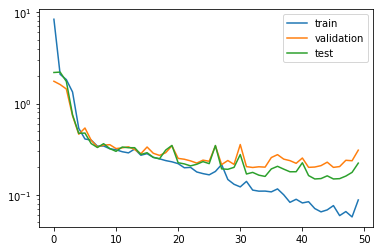

5. L = 10, sigma = 0.1, weight_decay = 0.01
Initialised MolLoader with 1713 compounds.
    sigma=0.1, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.1, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.1, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Finished in 1975.2366s.                                


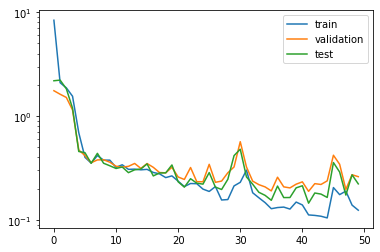

6. L = 10, sigma = 1.0, weight_decay = 0.0
Initialised MolLoader with 1713 compounds.
    sigma=1.0, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=1.0, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=1.0, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
), number of epochs: 50, validation epochs: 5
Finished in 1998.2864s.                                


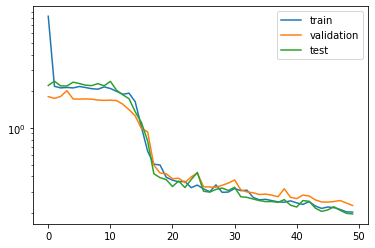

7. L = 10, sigma = 1.0, weight_decay = 0.001
Initialised MolLoader with 1713 compounds.
    sigma=1.0, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=1.0, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=1.0, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
), number of epochs: 50, validation epochs: 5
Finished in 1878.6006s.                                


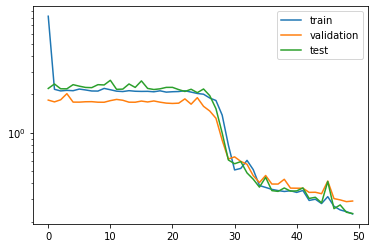

8. L = 10, sigma = 1.0, weight_decay = 0.01
Initialised MolLoader with 1713 compounds.
    sigma=1.0, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=1.0, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=1.0, L=10, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Finished in 1926.1769s.                                


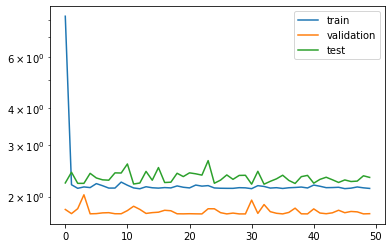

9. L = 12.8, sigma = 0.01, weight_decay = 0.0
Initialised MolLoader with 1713 compounds.
    sigma=0.01, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.01, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.01, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
), number of epochs: 50, validation epochs: 5
Finished in 1250.8217s.                                


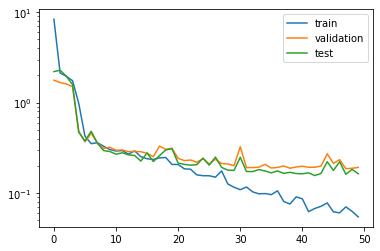

10. L = 12.8, sigma = 0.01, weight_decay = 0.001
Initialised MolLoader with 1713 compounds.
    sigma=0.01, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.01, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.01, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
), number of epochs: 50, validation epochs: 5
Finished in 1237.3819s.                                


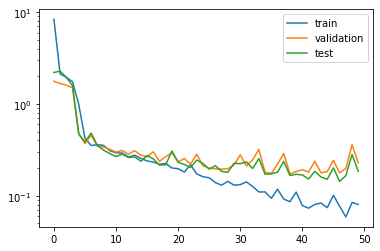

11. L = 12.8, sigma = 0.01, weight_decay = 0.01
Initialised MolLoader with 1713 compounds.
    sigma=0.01, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.01, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.01, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Finished in 1234.1781s.                                


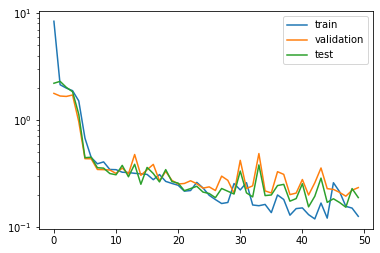

12. L = 12.8, sigma = 0.1, weight_decay = 0.0
Initialised MolLoader with 1713 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
), number of epochs: 50, validation epochs: 5
Finished in 1231.7789s.                                


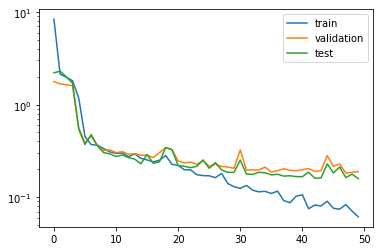

13. L = 12.8, sigma = 0.1, weight_decay = 0.001
Initialised MolLoader with 1713 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
), number of epochs: 50, validation epochs: 5
Finished in 1196.5324s.                                


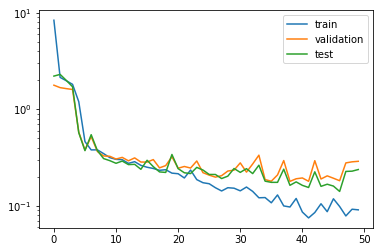

14. L = 12.8, sigma = 0.1, weight_decay = 0.01
Initialised MolLoader with 1713 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Finished in 1233.9546s.                                


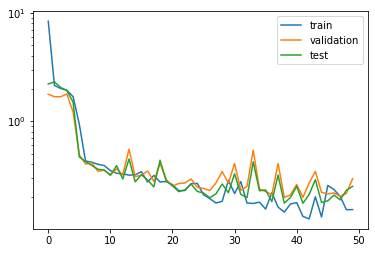

15. L = 12.8, sigma = 1.0, weight_decay = 0.0
Initialised MolLoader with 1713 compounds.
    sigma=1.0, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=1.0, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=1.0, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
), number of epochs: 50, validation epochs: 5
Finished in 1234.5250s.                                


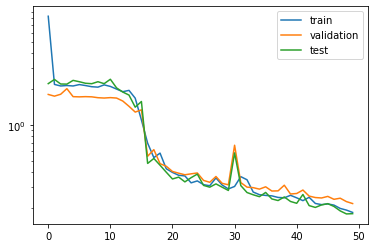

16. L = 12.8, sigma = 1.0, weight_decay = 0.001
Initialised MolLoader with 1713 compounds.
    sigma=1.0, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=1.0, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=1.0, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
), number of epochs: 50, validation epochs: 5
Finished in 1244.2889s.                                


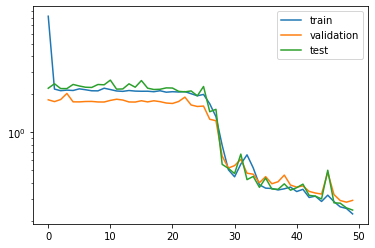

17. L = 12.8, sigma = 1.0, weight_decay = 0.01
Initialised MolLoader with 1713 compounds.
    sigma=1.0, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=1.0, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=1.0, L=12.8, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Finished in 1234.0707s.                                


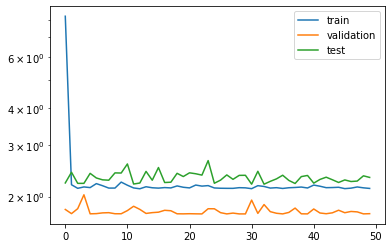

18. L = 15, sigma = 0.01, weight_decay = 0.0
Initialised MolLoader with 1713 compounds.
    sigma=0.01, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.01, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.01, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
), number of epochs: 50, validation epochs: 5
Finished in 1012.3325s.                                


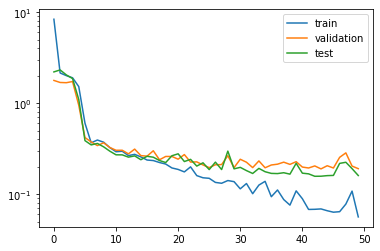

19. L = 15, sigma = 0.01, weight_decay = 0.001
Initialised MolLoader with 1713 compounds.
    sigma=0.01, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.01, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.01, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
), number of epochs: 50, validation epochs: 5
Finished in 1015.0755s.                                


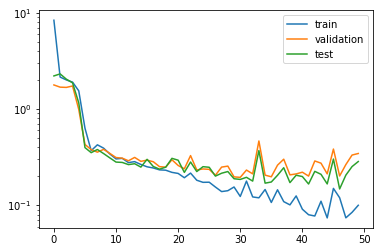

20. L = 15, sigma = 0.01, weight_decay = 0.01
Initialised MolLoader with 1713 compounds.
    sigma=0.01, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.01, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.01, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Finished in 1016.9381s.                                


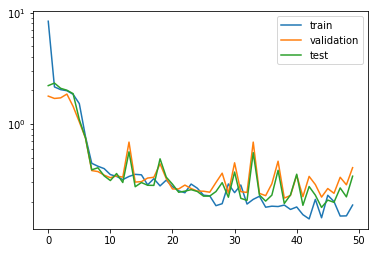

21. L = 15, sigma = 0.1, weight_decay = 0.0
Initialised MolLoader with 1713 compounds.
    sigma=0.1, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.1, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.1, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
), number of epochs: 50, validation epochs: 5
Finished in 1019.6928s.                                


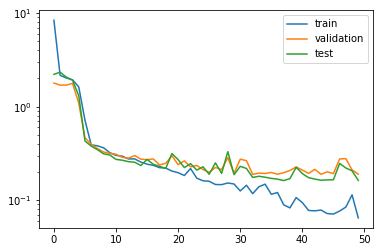

22. L = 15, sigma = 0.1, weight_decay = 0.001
Initialised MolLoader with 1713 compounds.
    sigma=0.1, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.1, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.1, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
), number of epochs: 50, validation epochs: 5
Finished in 1024.5586s.                                


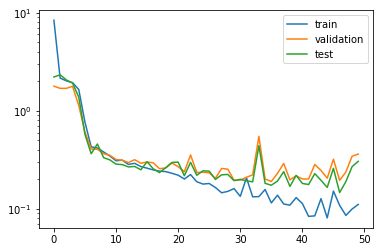

23. L = 15, sigma = 0.1, weight_decay = 0.01
Initialised MolLoader with 1713 compounds.
    sigma=0.1, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=0.1, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=0.1, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Finished in 1013.1239s.                                


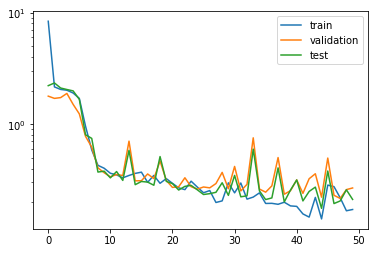

24. L = 15, sigma = 1.0, weight_decay = 0.0
Initialised MolLoader with 1713 compounds.
    sigma=1.0, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=1.0, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=1.0, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
), number of epochs: 50, validation epochs: 5
Finished in 1018.1763s.                                


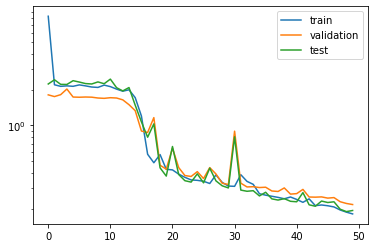

25. L = 15, sigma = 1.0, weight_decay = 0.001
Initialised MolLoader with 1713 compounds.
    sigma=1.0, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=1.0, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=1.0, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
), number of epochs: 50, validation epochs: 5
Finished in 1021.8851s.                                


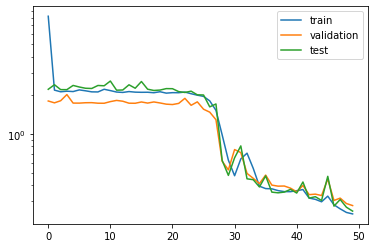

26. L = 15, sigma = 1.0, weight_decay = 0.01
Initialised MolLoader with 1713 compounds.
    sigma=1.0, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 95 compounds.
    sigma=1.0, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 96 compounds.
    sigma=1.0, L=15, N=32, nchannel=62, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Finished in 1023.9189s.                                


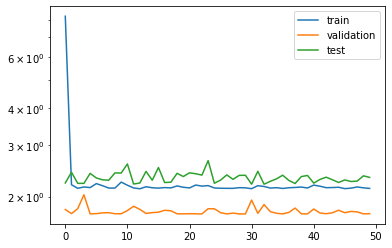

In [13]:
device = get_default_device()

results = []



for i, params in enumerate(param_grid):
    L = params["L"]
    sigma = params["sigma"]
    weight_decay = params["weight_decay"]
    print(f"{i}. L = {L}, sigma = {sigma}, weight_decay = {weight_decay}")

    seed_everything()
    
    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     device=device, mode='cartesian')

    ml_val = MolLoader(val_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='cartesian')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='cartesian')
    
    

    best_net = fit(epochs, net, ml_train, ml_val, ml_test, torch.optim.Adam, lr=0.001,
                   weight_decay=weight_decay, val_epochs=5, verbose=False)
    
    ml_pred = ml_train
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
    ys_train, y_hats_train = predict_epochs(best_net, ml_pred, epochs=5)

    
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
    ys_train_orig, y_hats_train_orig = predict_epochs(best_net, ml_pred, epochs=5)

    
    ml_pred = ml_val
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
    ys, y_hats = predict_epochs(best_net, ml_pred, epochs=5)

    
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
    ys_orig, y_hats_orig = predict_epochs(best_net, ml_pred, epochs=5)

    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
    ys_test, y_hats_test = predict_epochs(best_net, ml_pred, epochs=5)

    
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
    ys_test_orig, y_hats_test_orig = predict_epochs(best_net, ml_pred, epochs=5)
 
    
    results.append({"params":params,
                    
                    "train": np.mean((ys_train - y_hats_train)**2),
                    "train_orig": np.mean((ys_train_orig - y_hats_train_orig)**2),
                    
                    "val": np.mean((ys - y_hats)**2),
                    "val_orig": np.mean((ys_orig - y_hats_orig)**2),
                    
                    "test": np.mean((ys_test - y_hats_test)**2),
                    "test_orig": np.mean((ys_test_orig - y_hats_test_orig)**2)
                   })

In [17]:
for res in sorted(results, key=lambda x: x["val"]):
    print(res)

{'params': {'L': 10, 'sigma': 0.01, 'weight_decay': 0.01}, 'train': 0.076003596, 'train_orig': 0.13330907, 'val': 0.17570299, 'val_orig': 0.2503935, 'test': 0.13054188, 'test_orig': 0.21040511}
{'params': {'L': 12.8, 'sigma': 0.01, 'weight_decay': 0.001}, 'train': 0.06623926, 'train_orig': 0.09544582, 'val': 0.17574656, 'val_orig': 0.1937382, 'test': 0.16285397, 'test_orig': 0.20905977}
{'params': {'L': 10, 'sigma': 0.1, 'weight_decay': 0.01}, 'train': 0.08924735, 'train_orig': 0.16518977, 'val': 0.17941387, 'val_orig': 0.31382233, 'test': 0.14238349, 'test_orig': 0.2429772}
{'params': {'L': 12.8, 'sigma': 0.1, 'weight_decay': 0.001}, 'train': 0.07371973, 'train_orig': 0.10400406, 'val': 0.18275027, 'val_orig': 0.19863905, 'test': 0.16091815, 'test_orig': 0.20624532}
{'params': {'L': 12.8, 'sigma': 0.01, 'weight_decay': 0.0}, 'train': 0.043414477, 'train_orig': 0.060876302, 'val': 0.18366909, 'val_orig': 0.20224796, 'test': 0.16232012, 'test_orig': 0.1965107}
{'params': {'L': 12.8, 'si